In [1]:
import qctoolkit as qtk
import glob, os, re
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt

%matplotlib inline
qtk.setting.quiet = True

In [2]:
def freeList(sys):
    if sys != 'N2':
        element_strs = re.findall('[A-Z][^A-Z]*', sys)
        elements = [qtk.element[e] for e in element_strs]
    else:
        elements = [qtk.element['N'], qtk.element['N']]
    outs = []
    for e in elements:
        for out in frees:
            if out.element == e:
                outs.append(out)
        #outs.append([out for out in frees if out.element.symbol == e.symbol][0])
    return outs

def getOut(sys, mols, x):
    out_list = [out for out in mols if sys in out.name]
    name_list = [out.name for out in out_list]
    flag = 'd%5.3f.out' % x
    match_list = filter(lambda x: flag in x, name_list)
    if len(match_list) > 0:
        name = match_list[-1]
        ind = name_list.index(name)
        return out_list[ind]
    else:
        return None

def Eele(sys, x_list, mols):
    elements = freeList(sys)
    Si_e = freeList('Si')[0]
    Si_E = Si_e.Et
    freeE = sum([(e.Et) for e in elements])
    if sys != 'Si':
        EList = []
        for x in x_list:
            out = getOut(sys, mols, x)
            if out is not None:
                EList.append(out.Et - out.nuclear_repulsion)
            else:
                EList.append(np.nan)
        # set first energy as silicon
        EList[0] = Si_E
    else:
        EList = [Si_E for i in x_list]

    return EList

def Etot(sys, x_list, mols):
    elements = freeList(sys)
    Si_e = freeList('Si')[0]
    Si_E = Si_e.Et
    freeE = sum([(e.Et) for e in elements])
    if sys != 'Si':
        EList = []
        for x in x_list:
            out = getOut(sys, mols, x)
            if out is not None:
                EList.append(out.Et - freeE)
            else:
                EList.append(np.nan)
        # set first energy as silicon
    else:
        EList = [0 for i in x_list]

    return EList

def Ediff(sys, x_list, mols1, mols2):
    EList = []
    for x in x_list:
        out1 = getOut(sys, mols1, x)
        out2 = getOut(sys, mols2, x)
        if out1 is not None and out2 is not None:
            diff = out1.Et - out2.Et
            #diff.inUnit('Eh')
            if abs(diff) < 0.5:
                #diff.inUnit('kcal')
                EList.append(diff)
            else:
                EList.append(np.nan)
        else:
            EList.append(np.nan)
    return EList

def plot3DLines(E_function, ax, x, *molList, **kwargs):

    if 'x_range' in kwargs:
        x_range = kwargs['x_range']
        x_min = x_range[0]
        x_max = x_range[1]
        x_new = [d for d in x if d > x_min and d < x_max]
        x = x_new
    else:
        x_min = min(x)
        x_max = max(x)
    y = range(len(sys_plot))
    X, Y = np.meshgrid(x, y)
    cross_section = []
    cross_ind = []
    if 'offset' in kwargs:
        offset = kwargs['offset']
    else:
        offset = 0

    new_Z = True
    for i in range(len(sys_plot)):
        sys = sys_plot[i]
        y = [i for _ in x]
        z = E_function(sys, x, *molList) # <---- construct electronic energy list
        if 'z_range' in kwargs:
            z_min = kwargs['z_range'][0]
            z_max = kwargs['z_range'][1]
            for j in range(len(z)):
                if z[j] > z_max or z[j] < z_min:
                    z[j] = np.nan
        
        if new_Z:
            new_Z = False
            Z = np.atleast_2d([z])
        else:
            Z = np.vstack([Z, z])
        cross = []
        for c in cross_coord:
            x_np = np.array(x)
            ind = np.argmin(abs(x_np - c))
            if x[ind] < x_max and x[ind] > x_min:
                if ind not in cross_ind :
                    cross_ind.append(ind)
                cross.append(z[ind])
        cross_section.append(cross)
        ax.plot(x, y, z, color='b')

    cross_section = np.array(cross_section).T
    for i in range(len(cross_section)):
        z = cross_section[i]
        x_ = [x[cross_ind[i]] for _ in z]
        y = range(len(z))
        ax.plot(x_,y,z, color='r', ls=':')
    if 'z_range' in kwargs:
        ax.set_zlim([z_min, z_max])
        offset = z_min
    ax.contour(X, Y, Z, offset = offset, colors='k')

    y_labels = copy.deepcopy(sys_plot)
    y_labels[0] = 'N$_2$'
    ax.xaxis.set_rotate_label(False) 
    ax.zaxis.set_rotate_label(False)
    ax.set_yticklabels(y_labels,rotation=-20)
    ax.set_yticklabels(y_labels,rotation=-20)
    ax.set_xlabel('$d$ $[\AA]$', rotation = 0, fontsize=15, labelpad=15)
    if 'angle' in kwargs:
        print 'yo'
        ax.view_init(20, kwargs['angle'])
    else:
        ax.view_init(20, -40)
    ax.set_xlim([x_min, x_max])

    
    return ax
    
def loadMol(out_files):
    mols = []
    for out in out_files:
        path, name = os.path.split(out)
        sys, root = name.split('-d')
        d = float(root.replace('.out', ''))
        if sys not in sys_list:
            sys_list.append(sys)
        if d not in d_list:
            d_list.append(d)
        qout = qtk.QMOut(out, program='nwchem')
        #qout.inUnit('kcal')
        mols.append(qout)
    return mols

def loadMol_Z(out_files):
    mols = []
    for out in out_files:
        path, name = os.path.split(out)
        Nd, c = name.split('_c')
        c = float(c.replace('.out', ''))
        N, d = Nd.split('_d')
        d = float(d)
        
        #sys, root = name.split('-d')
        #d = float(root.replace('.out', ''))
        #if sys not in sys_list:
        #    sys_list.append(sys)
        if d not in d_list:
            d_list.append(d)
        if c not in c_list:
            c_list.append(c)
        qout = qtk.QMOut(out, program='nwchem')
        qout.d = float(d)
        qout.c = float(c)
        mols.append(qout)
    return mols

In [3]:
out_files = sorted(glob.glob('toLocal_new/*/*-d*.out'))
out_files_free = sorted(glob.glob('toLocal_new/*/*-free*.out'))
out_t_files = sorted(glob.glob('toLocal_redo/*/*-d*.out'))
out_z_files = sorted(glob.glob('NZScan_new/*/*.out'))

sys_list = []
d_list = []
c_list = []
e_list = []

mols = loadMol(out_files)
mols_t = loadMol(out_t_files)
mols_z = loadMol_Z(out_z_files)

frees = []
for out in out_files_free:
    name = out.split('free-')[-1].replace('.out', '')
    e_list.append(qtk.element[name])
    qout = qtk.QMOut(out, program='nwchem')
    #qout.inUnit('kcal')
    qout.element = e_list[-1]
    frees.append(qout)
    
E_Si = freeList('Si')[0].Et

Energy plots as a function of $\lambda$
=======================================

yo


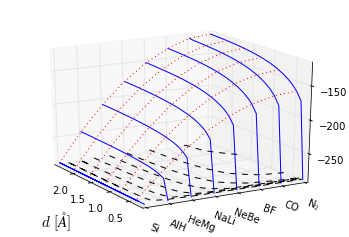

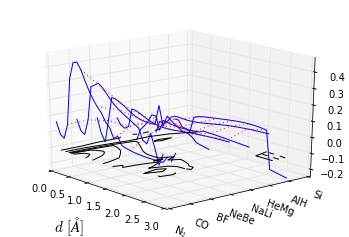

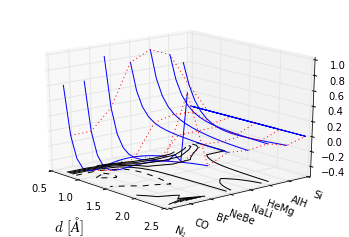

In [4]:
sys_plot = ['N2', 'CO', 'BF', 'NeBe', 'NaLi', 'HeMg', 'AlH', 'Si']
cross_coord = np.linspace(0.4,2.5,6)
#cross_coord = [0.5, 1.5, 2.5]

# electronic energy contour plot
#cross_coord = [0.5, 1.5, 2.5]
fig = plt.figure('E_electronic')
ax = fig.gca(projection='3d')
ax = plot3DLines(Eele, ax, d_list, mols, offset = E_Si, x_range = [0.2, 2.5], angle=150)      # <---- fill ax plot with data
plt.autoscale()
plt.savefig("Eele.png",bbox_inches='tight')

fig = plt.figure('triplet-singlet')
ax = fig.gca(projection='3d')
ax = plot3DLines(Ediff, ax, d_list, mols_t, mols, offset = -0.1)
plt.savefig("Ediff.png",bbox_inches='tight')

fig = plt.figure('E_total')
ax = fig.gca(projection='3d')
#cross_coord = [0.9, 1.2, 1.5]
ax = plot3DLines(Etot, ax, d_list, mols, 
                 x_range = [0.5, 2.5], z_range = [-0.5, 1])
plt.savefig("Etot.png",bbox_inches='tight')

Higher order contribution from fitting even order polynomials
=============================================================

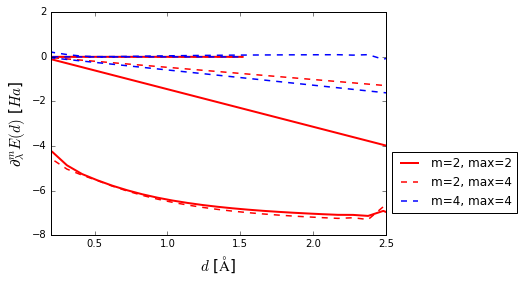

In [5]:
from scipy.optimize import minimize
from scipy.special import factorial

def alPlot(i):
    out_list = []
    for sys in sys_plot:
        out_list.append(Eele(sys, d_list, mols)[i])
    return np.array(out_list)

def polyFit(i, n = 2):
    true = alPlot(i)
    a0 = true[0]
    
    def polynomial(cef):
        x_list = np.array(range(1, 8))
        weight = np.array([1/float(x**3) for x in x_list])
        out = np.array([a0 for _ in x_list])
        for m in range(len(cef)):
            order = (m + 1)*2
            new_term = cef[m] * x_list**order / float(factorial(order))
            out = out + new_term
        final = [a0]
        final.extend(out)
        return np.array(final)
    
    def penalty(cef):
        fit = polynomial(cef)
        x_list = np.array(range(1, 8))
        weight = [1]
        weight.extend(np.array([1/float(x**2) for x in x_list]))
        return sum(((fit - true) * weight)**2)
        #return sum(((fit - true))**2)
    
    #result = penalty([0,0])
    opt = minimize(penalty, [0 for _ in range(n)], method='nelder-mead')
    result = polynomial(opt.x)
    return result, opt.x



def orderContribution(max_order, ax, **kwargs):
    cl = ['r','b','g','y']
    ls = kwargs['ls']
    lw = kwargs['linewidth']
    contributions = []
    for d in range(1,len(d_list[:-5])):
        contributions.append(polyFit(d,max_order)[1])
    contributions = np.array(contributions)
    _, order = contributions.shape

    for o in range(order):
        plt.plot(d_list[1:-5], contributions[:,o], 
                 label='m=%d, max=%s' % (((o+1)*2), max_order*2), 
                 ls=ls, color=cl[o],
                 linewidth = lw,
                )
    
    
fig, ax = plt.subplots()
orderContribution(1, ax, ls='-',linewidth=2)
orderContribution(2, ax, ls='--',linewidth=1.5)
#orderContribution(3, ax, ls='-.',linewidth=1)
#orderContribution(4, ax, ls=':',linewidth=0.5)

plt.legend(loc=(1.02,0.1))
plt.xlim([0.2,2.5])
ax.set_xlabel(r'$d$ [$\rm \AA$]', fontsize=15)
ax.set_ylabel(r'$\partial_\lambda^m E(d)$ [$Ha$]', fontsize=15)
plt.savefig("err.png",bbox_inches='tight', dpi=900)

Higher order contribution from Z scans
======================================

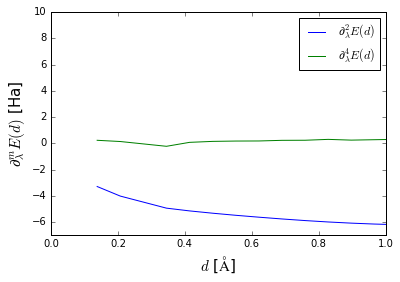

In [6]:
def getMolD(i, mols):
    if len(mols) > 0:
        return [mol for mol in mols if mol.d == d_list[i]]
    else:
        return []

def diffN(i_d, mols, **kwargs):
    
    def diff(x, h):
        dx = [2*(x[1] - x[0]) / (h)**2]
        for i in range(1, len(x)-1):
            dx.append((x[i+1] - 2*x[i] + x[i-1]) / h**2)
        return dx
        
    
    h = c_list[1] - c_list[0]
    try:
        order = kwargs['order']
    except:
        order = 2
    mols_d = getMolD(i_d, mols)
    if len(mols_d) > 0:
        x = [mol.Et - mol.nuclear_repulsion for mol in mols_d]
        y = np.array(x) - x[0]
        axis = [mol.c for mol in mols_d]
        #plt.plot(axis, y)
        dxN = []
        for i in range(4):
        #for i in range(2):
            x = diff(x, h)
            dxN.append(x[0])
        return [dxN, d_list[i_d]]
    else:
        return np.nan
        
dE = []
for i in range(len(d_list)):
    dE.append(diffN(i, mols_z))

out = filter(lambda x: x is not np.nan, dE)
x = np.array([o[1] for o in out])[:, np.newaxis]
ys = np.array([o[0] for o in out])


result = np.hstack([x, ys])
ind = np.argsort(result[:,0])
result = result[ind]
#for _ in result[:,1]:
#    print np.round(_, decimals=3)
x = result[:,0]
y2 = result[:,1]
y4 = result[:,2]
plt.plot(x,y2, label='$\partial_\lambda^2 E(d)$')
plt.plot(x,y4, label='$\partial_\lambda^4 E(d)$')
plt.ylim([-7,10])
plt.xlim([0,1])
plt.xlabel(r'$d$ [$\rm \AA$]', fontsize=15)
plt.ylabel(r'$\partial_\lambda^m E(d)$ [Ha]', fontsize=15)
plt.legend(loc=1)
plt.savefig("dE_FD.png",bbox_inches='tight', dpi=600)


#diffN(3, mols_z)
#diffN(5, mols_z)

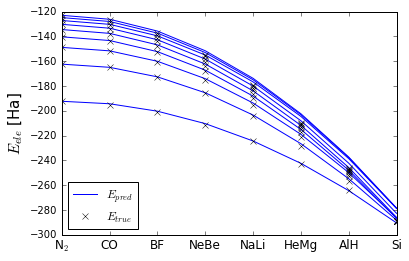

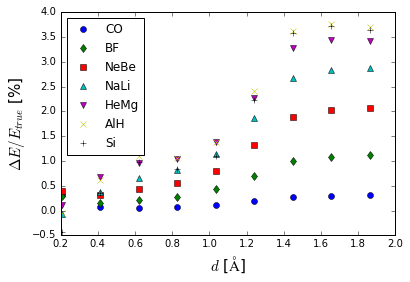

In [7]:
def DFPlot(d, label_flag=True):
    if min(abs(x - d)) < 1E-3:
        i = np.argmin((abs(x-d)))
        dE2 = y2[i]
        Z = np.array(range(8))
        N2_out = getOut('N2', mols, float(d))
        if N2_out:
            pred = Z**2 * dE2/2.0 + (N2_out.Et - N2_out.nuclear_repulsion)
            true = []
            for sys in sys_plot:
                out = getOut(sys, mols, float(d))
                try:
                    true.append(out.Et - out.nuclear_repulsion)
                except:
                    true.append(E_Si)
            true = np.array(true)
            if label_flag:
                plt.plot(pred, color='b', label=r'$E_{pred}$')
                plt.plot(true, color='k', ls='', marker = 'x', label=r'$E_{true}$')
            else:
                plt.plot(pred, color='b')
                plt.plot(true, color='k', ls='', marker = 'x')
            return ((true - pred)/true)[1:] * 100


fig, ax = plt.subplots()
err = []            
for d in x:
    if len(err) == 0:
        e = DFPlot(d)
    else:
        e = DFPlot(d, False)
    if e is not None:
        vec = [d]
        vec.extend(e)
        err.append(vec)
err = np.array(err)
x_label = copy.deepcopy(sys_plot)
x_label[0] = r'N$_2$'
ax.set_xticklabels(x_label, fontsize=12)
ax.set_ylabel(r'$E_{ele}$ [Ha]', fontsize=15)
plt.legend(loc=3, numpoints=1)
plt.savefig("EpEt.png",bbox_inches='tight', dpi=600)

plt.figure()
marker_list = ['', 'o','d','s','^','v','x','+']
for sys in range(1, err.shape[1]):
    plt.plot(err[:, 0], err[:, sys], ls='', label=sys_plot[sys],marker = marker_list[sys])
plt.legend(loc=2, numpoints=1)
plt.xlabel(r'$d$ [$\rm \AA$]', fontsize=15)
plt.ylabel(r'$\Delta E/E_{true}$ [%]', fontsize=15)
#plt.savefig("dE2_err.png",bbox_inches='tight', dpi=600)
    #err.append([DFPlot(d), d])
#fig = plt.figure()
#err_matrix = []
#for e in err:'
#    d = e[1]
#    y = e[0]
#    if y is not None:
#        d = [d for _ in y]
#        plt.plot(d, y)

[-4.0049070389613917, -5.1347689600333979, -5.6131784003810026, -5.9774078385999019, -6.1848551194998436, -6.222553040515777, -6.1904044002858427, -6.2700052797026729, -6.3533499201184895]
[0.012427960741465433, -0.010240734521630088, -0.028199769477815471, -0.024034924340895134, -0.031955840480164928, -0.064699525496861129, -0.10350601819441767, -0.10747919928561313, -0.10536724081304494]


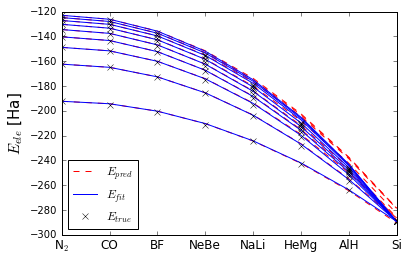

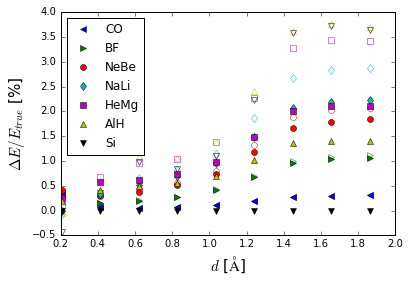

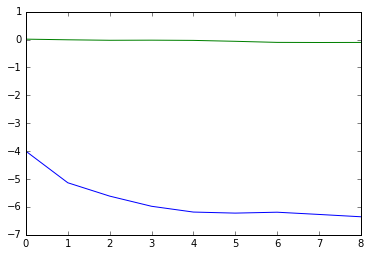

In [45]:
def E4Fit(d, label_flag=True, order=2):
    if min(abs(x - d)) < 1E-3:
        i = np.argmin((abs(x-d)))
        dE2 = y2[i]
        Z = np.array(range(8))
        N2_out = getOut('N2', mols, float(d))
        if N2_out:
            pred_2 = 0.5*dE2 * Z**2 + (N2_out.Et - N2_out.nuclear_repulsion)
            dE4 = (24 * (E_Si - pred_2[-1]))/ (7**4)
            pred_4 = pred_2 + Z**4/24.0 * dE4
            
            if order == 2:
                pred = pred_2
                ls = '--'
                c = 'r'
                txt = r'$E_{pred}$'
                dE = dE2
            elif order == 4:
                pred = pred_4
                ls = '-'
                c = 'b'
                txt = r'$E_{fit}$'
                dE = dE4
            #pred_4 = pred_2
            #print dE4

            true = []
            for sys in sys_plot:
                out = getOut(sys, mols, float(d))
                try:
                    true.append(out.Et - out.nuclear_repulsion)
                except:
                    true.append(E_Si)
            true = np.array(true)
            if label_flag:
                plt.plot(pred, color=c, ls=ls, label=txt)
                if order == 4:
                    plt.plot(true, color='k', ls='', marker = 'x', label=r'$E_{true}$')
            else:
                plt.plot(pred, color=c, ls = ls)
                if order == 4:
                    plt.plot(true, color='k', ls='', marker = 'x')
            return ((true - pred)/true)[1:] * 100, dE
        else:
            return None, None

        
fig, ax = plt.subplots()

def orderPlot(order):
    err = []    
    dE_list = []
    for d in x:
        if len(err) == 0:
            e, dE = E4Fit(d, True, order)
        else:
            e, dE = E4Fit(d, False, order)
        if e is not None:
            vec = [d]
            vec.extend(e)
            err.append(vec)
            dE_list.append(dE)
    err = np.array(err)
    x_label = copy.deepcopy(sys_plot)
    x_label[0] = r'N$_2$'
    ax.set_xticklabels(x_label, fontsize=12)
    ax.set_ylabel(r'$E_{ele}$ [Ha]', fontsize=15)
    plt.legend(loc=3, numpoints=1)
    return err, dE_list
    #plt.savefig("EpEt.png",bbox_inches='tight', dpi=600)

def errPlot(err, empty=False):
    marker_list = ['', '<', '>', 'o','d','s','^','v']
    color_list = ['', 'b', 'g', 'r', 'c', 'm', 'y', 'k']
    for sys in range(1, err.shape[1]):
        if not empty:
            plt.plot(err[:, 0], err[:, sys], 
                     ls='', 
                     label=sys_plot[sys],
                     marker = marker_list[sys], 
                     color = color_list[sys])
        else:
            plt.plot(err[:, 0], err[:, sys], 
                     ls='', 
                     marker = marker_list[sys], 
                     markerfacecolor='none',
                     markeredgecolor=color_list[sys])
    plt.legend(loc=2, numpoints=1)
    plt.xlabel(r'$d$ [$\rm \AA$]', fontsize=15)
    plt.ylabel(r'$\Delta E/E_{true}$ [%]', fontsize=15)

    
err2, dE_2 = orderPlot(2)
err4, dE_4 = orderPlot(4)
plt.savefig("EtEt.png",bbox_inches='tight', dpi=600)

plt.figure()
errPlot(err2, True)
errPlot(err4, False)
plt.savefig("err.png",bbox_inches='tight', dpi=600)

print dE_2
print dE_4
        
plt.figure()
plt.plot(dE_2)
plt.plot(dE_4)
